<a href="https://colab.research.google.com/github/130ndim/dul_2021/blob/hw8/Homework/hw8/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 281 (delta 68), reused 56 (delta 51), pack-reused 163
Receiving objects: 100% (281/281), 53.75 MiB | 27.06 MiB/s, done.
Resolving deltas: 100% (125/125), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./dul

In [4]:
import numpy as np

import torch
from torch import nn, distributions as dist, optim as opt
from torch.utils import data

from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


In [5]:
class KMM(nn.Module):
    def __init__(self, hd=128, sigma=1.0):
        super().__init__()
        self._r = nn.Sequential(nn.Linear(1, hd), 
                                nn.ReLU(True),
                                nn.Linear(hd, hd), 
                                nn.ReLU(True),
                                nn.Linear(hd, 1),
                                nn.Softplus())
        self._sigma = sigma
        
    @property
    def device(self):
        return next(self.parameters()).device
        
    def forward(self, x):
        return self._r(x[:, None])[:, -1]
    
    def _rbf(self, x, y):
        return (-(x[:, None] - y).pow(2) / 2.0 / self._sigma).exp()
        
        
    def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
        loader_nu = data.DataLoader(data_nu, 
                                    batch_size=batch_size, 
                                    drop_last=True,
                                    shuffle=True)
        
        loader_de = data.DataLoader(data_de, 
                                    batch_size=batch_size, 
                                    drop_last=True,
                                    shuffle=True)
        

        optim = opt.Adam(self.parameters(), lr=lr)

        
        bar = tqdm(range(num_epochs))
        for epoch in bar:
            acc_loss = 0.

            for (b_nu, b_de) in zip(loader_nu, loader_de):
                b_nu, b_de = b_nu.to(self.device), b_de.to(self.device)
                
                r_de = self(b_de)

                loss = (r_de @ self._rbf(b_de, b_de) @ r_de) - 2 * (r_de @ self._rbf(b_de, b_nu)).sum()
                loss /= batch_size ** 2
                
                optim.zero_grad()
                loss.backward()
                optim.step()
                
                acc_loss += loss.item()
            
            bar.set_postfix_str(f'loss = {acc_loss / min(len(loader_nu), len(loader_de))}')
            

In [6]:
# distributions

In [7]:
def q1(data_nu, data_de):
    """
    data_nu - An [n_nu] dataset with samples from numerator's distribution
    data_de - An [n_de] dataset with samples from denominators's distribution

    Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
    """

    model = KMM(64, 0.05)
    model.to(DEVICE)
    model.fit(data_nu.astype(np.float32), data_de.astype(np.float32), lr=1e-3, batch_size=512, num_epochs=1000)
    
    with torch.no_grad():
        out = model(torch.linspace(-2.0, 2.0, 100, device=DEVICE)).cpu().numpy()
        
    return out
    # your code goes here

    # you need to calculate density ratio on x and return it
    # x = np.linspace(-2., 2, num=100)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

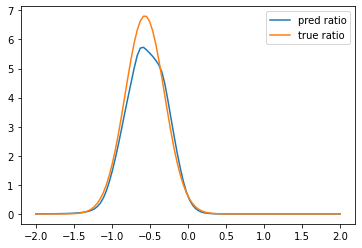

In [8]:
q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [6]:
from torch.nn import functional as F, utils

In [50]:
class Encoder(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self._seq = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU(),
        )
        self._lin = nn.Linear(4 * 4 * 128 + ld, ld)
        
    def forward(self, x, z):
        x = self._seq(x)
        x = torch.cat([x.view(-1, 4 * 4 * 128), z], dim=1)
        x = self._lin(x)
        return x
    

class Decoder(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self._lin = nn.Linear(ld, 4 * 4 * 128)
        self._seq = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1),
        )
        
    def forward(self, z):
        x = self._lin(z)
        x = x.view(-1, 128, 4, 4)
        x = self._seq(x)
        
        return x
    

class Classifier(nn.Module):
    def __init__(self, ld):
        super().__init__()
        self._seq = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
        )
        self._out = nn.Sequential(
            nn.Linear(4 * 4 * 128 + ld, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x, latent):
        x = self._seq(x)
        x = torch.cat([x.view(-1, 4 * 4 * 128), latent], dim=1)
        x = self._out(x)
        return x
    
    
class AVB(nn.Module):
    def __init__(self, ld=64, w_mp=0.0, d_freq=1):
        super().__init__()
        self._ld = ld
        self._w_mp = w_mp
        self._d_freq = d_freq
        
        self._enc = Encoder(ld)
        self._dec = Decoder(ld)
        self._clf = Classifier(ld)
        
    @property
    def device(self):
        return next(self.parameters()).device
        
    def _fused_losses(self, x):
        z_p = torch.randn(x.size(0), self._ld, device=x.device)
        z_q = self._enc(x, z_p)
        
        logd_p = self._clf(x, z_p)
        logd_q = self._clf(x, z_q)
        
        d_loss = F.binary_cross_entropy_with_logits(logd_p, torch.zeros_like(logd_p)) + F.binary_cross_entropy_with_logits(logd_q, torch.ones_like(logd_q))
        # d_loss = -(1 - logd_p.sigmoid()).clip(1e-5, 1 - 1e-5).log().mean() - logd_q.sigmoid().clip(1e-5, 1 - 1e-5).log().mean()

        rec = self._dec(z_q)
        
        g_loss = logd_q.mean() + F.binary_cross_entropy_with_logits(rec, x, reduction='sum') / x.size(0)

        return d_loss, g_loss

    def _clf_step(self, x):
        z_p = torch.randn(x.size(0), self._ld, device=x.device)
        z_q = self._enc(x, z_p)
        
        logd_p = self._clf(x, z_p)
        logd_q = self._clf(x, z_q)
        
        d_loss = (F.binary_cross_entropy_with_logits(logd_p, torch.zeros_like(logd_p) + self._w_mp * torch.rand_like(logd_p)) + 
                  F.binary_cross_entropy_with_logits(logd_q, torch.ones_like(logd_q) - self._w_mp * torch.rand_like(logd_q)))
        return d_loss

    def _gen_step(self, x):
        z_p = torch.randn(x.size(0), self._ld, device=x.device)
        z_q = self._enc(x, z_p)
        logd_q = self._clf(x, z_q)

        rec = self._dec(z_q)
        
        g_loss = logd_q.mean() + F.binary_cross_entropy_with_logits(rec, x, reduction='sum') / x.size(0)
        return g_loss
        
    @torch.no_grad()   
    def sample(self, n=100):
        z = torch.randn(n, self._ld, device=self.device)
        return self._dec(z).sigmoid()  
    
    def fit(self, train_data, test_data, n_epochs=20, lr=1e-3, bs=256, lr_gamma=0.1, n_decays=2):
        dl = data.DataLoader(train_data, batch_size=bs, shuffle=True, drop_last=True)
        test_dl = data.DataLoader(test_data, batch_size=bs, drop_last=True)
        
        g_opt = opt.Adam(list(self._enc.parameters()) + list(self._dec.parameters()), lr=lr)
        g_sch = opt.lr_scheduler.StepLR(g_opt, n_epochs // (n_decays + 1), lr_gamma)
        d_opt = opt.Adam(self._clf.parameters(), lr=lr)
        d_sch = opt.lr_scheduler.StepLR(d_opt, n_epochs // (n_decays + 1), lr_gamma)
        
        g_losses, d_losses, g_test_losses, d_test_losses = [], [], [], []
        
        bar = tqdm(total=n_epochs * (len(dl) + len(test_dl)), desc='Training')

        res_dict = {}

        for _ in range(n_epochs):

            res_dict.update({'g_lr': g_sch.get_last_lr()[0], 'd_lr': d_sch.get_last_lr()[0]})
            for i, batch in enumerate(dl):
                batch = batch.to(self.device)

                if i % self._d_freq == 0:
                    g_loss = self._gen_step(batch)
                    g_opt.zero_grad()
                    g_loss.backward()
                    # utils.clip_grad_norm_(list(self._enc.parameters()) + list(self._dec.parameters()), 0.1)
                    g_opt.step()
                    g_losses.append(g_loss.item())
                else:
                    g_losses.append(g_losses[-1])

                d_loss = self._clf_step(batch)

                d_opt.zero_grad()
                d_loss.backward()
                # utils.clip_grad_norm_(self._clf.parameters(), 0.1)
                d_opt.step()
                d_losses.append(d_loss.item())

                res_dict.update({'g_loss': g_losses[-1], 'd_loss': d_losses[-1]})

                bar.update(1)
                bar.set_postfix(res_dict)

            g_sch.step()
            d_sch.step()

            with torch.no_grad():
                d_ep_loss = g_ep_loss = 0.0
                for batch in test_dl:
                    batch = batch.to(self.device)

                    d_t_loss, g_t_loss = self._fused_losses(batch)
                    d_ep_loss += d_t_loss.item()
                    g_ep_loss += g_t_loss.item()

                    bar.update(1)

                d_test_losses.append(d_ep_loss / len(test_dl))
                g_test_losses.append(g_ep_loss / len(test_dl))

                res_dict.update({'g_t_loss': g_test_losses[-1], 'd_t_loss': d_test_losses[-1]})

                bar.set_postfix(res_dict)
                
                # d_loss.backward()
                # d_opt.step()
        
                
        return np.array(g_losses), np.array(d_losses), np.array(g_test_losses), np.array(d_test_losses)
                
        

In [55]:
def q2(train_data, test_data, *_, **__):
    """
    train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
    Returns
    - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
    - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
    - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
    """
    
    model = AVB(d_freq=5)
    model.to(DEVICE)
    elbo_losses, clf_losses, elbo_test_losses, clf_test_losses = model.fit(
        train_data.transpose(0, 3, 1, 2).astype(np.float32), 
        test_data.transpose(0, 3, 1, 2).astype(np.float32),
        n_epochs=50,
        lr_gamma=0.5,
    )

    sample = model.sample().cpu()

    return elbo_losses, clf_losses, elbo_test_losses, clf_test_losses, sample

Training:   0%|          | 0/13650 [00:00<?, ?it/s]

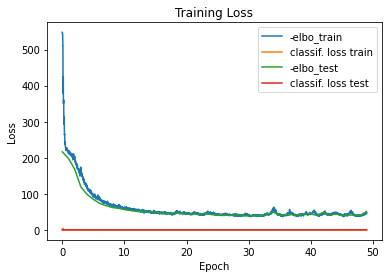

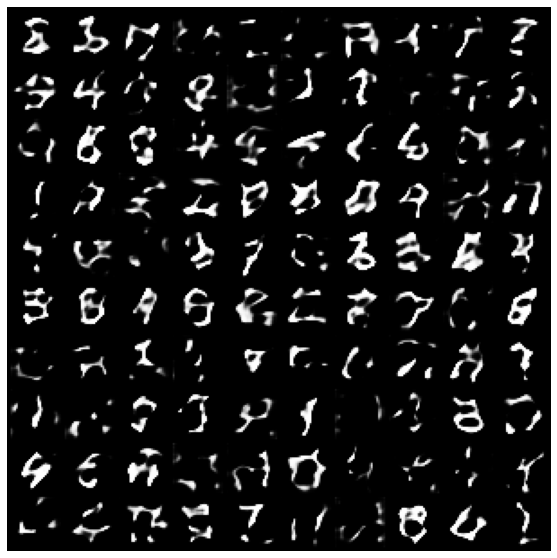

In [56]:
q2_results(q2)